In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load MNIST images 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_samples = mnist.train.num_examples
m_features = mnist.train.images.shape[1]
print("Number of Samples: {}. Feature Dimension: {}".format(n_samples, m_features))

Number of Samples: 55000. Feature Dimension: 784


### Data Visualization

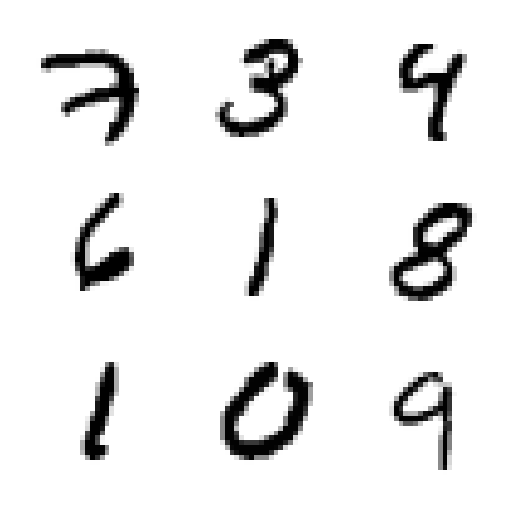

In [4]:
plt.figure(figsize=[6,6])
for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.imshow(np.reshape(-mnist.train.images[i], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))
    plt.axis('off')

### Variational Autoencoder Class
Variational Autoencoder consist of an encoder, a decoder and a loss function.

#### Encoder
Encoder network receives as input the image representation, in case of MNIST dataset it is a 28x28 pixel image.
The encoder *‘encodes’* the data which is 784-dimensional into a latent (hidden) representation space z, which is much less than 784 dimensions. 

In our class, the encoder calculates the mean and standard deviation of the gaussian which will produce the latent variable z.

#### Decoder
Decoder network receives as input the latent variable z. The decoder *‘decodes’* the real-valued numbers in z into 784 real-valued numbers between 0 and 1. Information is lost because it goes from a smaller to a larger dimensionality.

#### Loss function
The loss function of the variational autoencoder is the negative log-likelihood with a regularizer.
\begin{align}
L^{\tt{v}} & = \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) - D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)&\\
\end{align}

The first term is the reconstruction loss, or expected negative log-likelihood of the i-th datapoint. This term encourages the decoder to learn to reconstruct the data. If the decoder’s output does not reconstruct the data well, it will incur a large cost in this loss function.

The second term is a regularizer. This is the Kullback-Leibler divergence between the encoder’s distribution q(z∣x) and p(z). This divergence measures how much information is lost when using q to represent p. It is one measure of how close q is to p.

In [5]:
### Auxiliary Methods for Network Creation
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

In [6]:
class VariationalAutoencoder():
    
    # VAE initialization
    def __init__(self, **options ):
        #latent space dimension (z)
        self.latent_space_dim = options.get("latent_space_dim", 20)
        #number of hidden nodes in networks - subject to future improvements
        self.num_hidden = options.get("num_hidden", 500)
        self.sess = tf.Session()
    
    # Build a VAE from data X ( num_samples x num_features ) 
    def fit(self, X):
        self.num_samples = X.shape[0]
        self.num_features = X.shape[1]
        self.x = tf.placeholder(tf.float32, [None, self.num_features]) 
        self.data = X
    
    # Encoder network
    # input: data (num_samples x num_features )
    # output: parameters for variance and standard deviation
    def encode(self, X):
        with tf.variable_scope("encoder"):
            #first hidden_layer
            W1 = weight_variable([self.num_features, self.num_hidden]) 
            b1 = bias_variable([self.num_hidden])
            h1 = tf.nn.tanh( tf.matmul(X,W1) + b1 )
            
            #second hidden_layer
            W2 = weight_variable([self.num_hidden, self.num_hidden])
            b2 = bias_variable([self.num_hidden])
            h2 = tf.nn.tanh( tf.matmul(h1, W2) + b2 )
            
            #mean and sigma layer
            W3 = weight_variable([self.num_hidden,self.latent_space_dim])
            b3 = bias_variable([self.latent_space_dim])
            W_mean = tf.matmul(h2, W3 ) + b3 
            
            W4 = weight_variable([self.num_hidden,self.latent_space_dim])
            b4 = bias_variable([self.latent_space_dim])
            W_sigma = tf.matmul(h2,W4) + b4 
            
        return W_mean, W_sigma
    
    
    # Decoder network
    # input: representation z previously obtained from encoder
    # output: reconstruction of initial data X
    def decode(self,z):
        with tf.variable_scope("decoder"):
            #first hidden layer
            W1 = weight_variable([self.latent_space_dim, self.num_hidden])
            b1 = bias_variable([self.num_hidden])
            h1 = tf.nn.tanh(tf.matmul(z, W1) + b1)
            
            #second hidden layer
            W2 = weight_variable([self.num_hidden,self.num_hidden])
            b2 = bias_variable([self.num_hidden])
            h2 = tf.nn.tanh(tf.matmul(h1, W2) + b2 )
            
            #reconstruction layer
            W3 = weight_variable([self.num_hidden, self.num_features])
            b3 = bias_variable([self.num_features])
            generated = tf.nn.sigmoid( tf.matmul(h2, W3) + b3 )
            
        return generated    
    
    # cross_entropy(t,o) = -(t * log(o) + (1-t) * log(1-o)) 
    @staticmethod
    def binary_cross_entropy(x, x_reconstructed, offset = 1e-8):
        return -tf.reduce_sum( x * tf.log( offset + x_reconstructed ) + 
                              (1 - x) * tf.log( offset + 1 - x_reconstructed ) , 1)
    
    # divergence = -1/2 * sum( 1 + log(sigma^2) - sigma^2 - mean^2 )
    @staticmethod
    def KL_divergence(z_mean, z_sigma):
        return -0.5 * tf.reduce_sum(1 + tf.log(tf.square(z_sigma)) - 
                                    tf.square(z_sigma) - tf.square(z_mean), 1 ) 
    
    # Train VAE
    def train(self, **options ):
        batch_size = options.get("batch_size", 100 )
        epochs = options.get("epochs", 20)
        learning_rate = options.get("learning_rate", 0.001)
        
        # Calculate mean and std from input data
        self.z_mean, self.z_sigma = self.encode(self.x)

        # Reparametrization trick - add gaussian noise
        noise = tf.random_normal([batch_size, self.latent_space_dim], mean = 0 , stddev = 1, dtype= tf.float32)
        z = self.z_mean + self.z_sigma * noise
        
        # Construct data from latent sample z
        self.generated = self.decode(z)

        # Loss = Reconstruction loss + KL-divergence cost
        divergence_cost = self.KL_divergence(self.z_mean, self.z_sigma)
        reconstruction_loss = self.binary_cross_entropy(self.x, self.generated)
        total_loss = tf.reduce_mean(reconstruction_loss + divergence_cost)
        
        # Optimizer
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)
        
        self.sess.run(tf.initialize_all_variables())
        batches = int(self.num_samples/batch_size)
        
        # Number of iterations
        for epoch in range(epochs):
            avg_cost = 0
            avg_divergence = 0
            avg_reconstruction = 0
            
            # Iterate on each batch
            for i in range(batches):
                # Get current batch
                x_batch = self.data[i * batch_size: i * batch_size + batch_size ][:]
                
                # Train VAE and get current losses
                _, kl_cost, rec_loss, total_cost = self.sess.run( (train_step, divergence_cost, reconstruction_loss, total_loss ), 
                                                                  feed_dict={self.x:x_batch} )
                avg_divergence += np.mean( kl_cost )
                avg_reconstruction += np.mean( rec_loss )
                avg_cost += total_cost
            
            avg_reconstruction /= batches
            avg_divergence /= batches
            avg_cost /= batches
            print("Epoch: {}, Divergence={}, Reconstruction={}, Cost={}".format(epoch, avg_divergence, avg_reconstruction, avg_cost))

            
    # Visualize original and generated sample
    # input: sample with dimensions (1 x num_features)
    def visualize_generation(self, x_sample):
        x_reconstruct = self.sess.run(self.generated, feed_dict={self.x: x_sample})
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x_sample.reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(x_reconstruct[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
        plt.axis('off')

#### Testing Variational Autoencoder

In [7]:
# VAE Instantiation
VAE = VariationalAutoencoder(latent_space_dim = 20)

# Use MNIST images
VAE.fit(mnist.train.images)

# Train VAE
batch_size = 64
VAE.train(batch_size = batch_size, epochs = 10, learning_rate = 0.001 )

Epoch: 0, Divergence=74.0814271756, Reconstruction=199.609449464, Cost=273.690876651
Epoch: 1, Divergence=37.2701346938, Reconstruction=174.573390299, Cost=211.84352547
Epoch: 2, Divergence=63.6690825439, Reconstruction=173.130652307, Cost=236.799734771
Epoch: 3, Divergence=29.1018327862, Reconstruction=165.328607668, Cost=194.430440989
Epoch: 4, Divergence=25.9699227574, Reconstruction=154.902211004, Cost=180.872133692
Epoch: 5, Divergence=26.1603020944, Reconstruction=154.719204069, Cost=180.879505855
Epoch: 6, Divergence=20.5181058755, Reconstruction=147.914539981, Cost=168.432646248
Epoch: 7, Divergence=13.0161044306, Reconstruction=133.587953827, Cost=146.604058724
Epoch: 8, Divergence=15.5962938646, Reconstruction=135.626199236, Cost=151.222493013
Epoch: 9, Divergence=13.159309959, Reconstruction=124.745104345, Cost=137.90441462


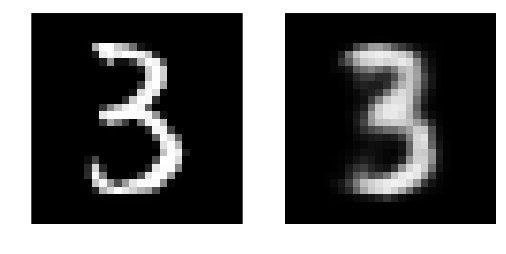

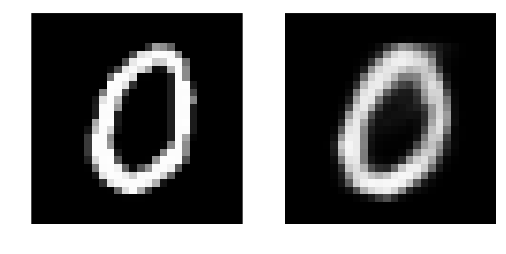

In [35]:
# Visualize custom image from MNIST test images
x_sample = mnist.test.next_batch(batch_size)[0]
image_index = 10
VAE.visualize_generation(x_sample[image_index:image_index + 1])
plt.figure
image_index = 11
VAE.visualize_generation(x_sample[image_index:image_index + 1])